In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [ ]:
training = spark.read.option("inferSchema","true").csv("BearTraining.csv",header=True)
testing = spark.read.option("inferSchema","true").csv("BearTesting.csv",header=True)

In [ ]:
training = training.select("Pupillary Distance", "Front Claws", "Ear Shape")
testing = testing.select("Pupillary Distance", "Front Claws", "Ear Shape", "Grizzly")

In [ ]:
training = training.na.drop()
testing = testing.na.drop()

In [ ]:
from pyspark.sql.functions import when

training = training.withColumn("Ear Shape", when(training["Ear Shape"] == "Pointed", 0).
                                                  when(training["Ear Shape"] == "Broad", 1).
                                                  when(training["Ear Shape"] == "Rounded", 2))

testing = testing.withColumn("Ear Shape", when(testing["Ear Shape"] == "Pointed", 0).
                                                when(testing["Ear Shape"] == "Broad", 1).
                                                when(testing["Ear Shape"] == "Rounded", 2))

testing = testing.withColumn("Grizzly", when(testing["Grizzly"] == "No", 0).
                                         when(testing["Grizzly"] == "Yes", 1))

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

colsTrain = training.columns
colsTest = testing.columns
colsTest.remove("Grizzly")

training = VectorAssembler(inputCols = colsTrain, outputCol = "Vector").transform(training)
testing = VectorAssembler(inputCols = colsTest, outputCol = "Vector").transform(testing)

In [ ]:
scaler = StandardScaler(inputCol = "Vector", outputCol = "features")
training = scaler.fit(training).transform(training)
testing = scaler.fit(testing).transform(testing)

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(2)
model = kmeans.fit(training)
predictions = model.transform(testing)

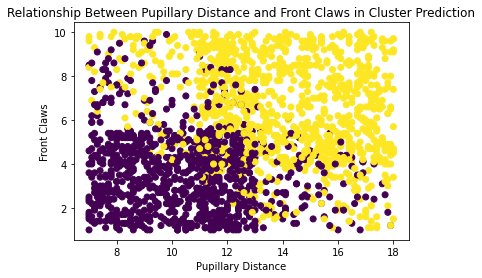

In [ ]:
import matplotlib.pyplot as plt

predictions = predictions.toPandas()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Pupillary Distance"], predictions["Front Claws"], c=predictions["prediction"])
ax.set_title('Relationship Between Pupillary Distance and Front Claws in Cluster Prediction')
ax.set_xlabel('Pupillary Distance')
ax.set_ylabel('Front Claws')
plt.show()

In [ ]:
c = 0
for index, row in predictions.iterrows():
    if row["Grizzly"] == row["prediction"]:
        c = c + 1

print("Accuracy: {}%".format(c / len(predictions) * 100))

Accuracy: 83.55%
